In [2]:
import pandas as pd
import numpy as np
import re

from torch import nn
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import *
import torchvision.models as models


import torch.nn as nn
from transformers import BertModel, BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from torch.nn import Transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
nltk.download('stopwords')

/home/vscode/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from text_process import process_text
training_dataset = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/15_after_processed/train.csv')
val_dataset = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/15_after_processed/val.csv')
testing_dataset = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/15_after_processed/test.csv')
training_dataset, val_dataset, testing_dataset = process_text(training_dataset, val_dataset, testing_dataset)
training_dataset.head()

,posting_id,image,image_phash,title,label_group,proc_title
0,train_2249428809,40d304f91be807fed3b796a158a034f7.jpg,bc69d33e86b491c1,AMTECH Klem C Set 3 Pcs - Catok Clamp 1 2 3 Inch,3685949317,amtech klem c set pcs catok clamp inch
1,train_1453612941,e05aa71652e2546dbc2a6a2d18cc4aa7.jpg,bcfcc1a80ee930da,Cetakan Kue Pukis 10 Lubang Pancong Teflon Ran...,2236232282,cetakan kue pukis lubang pancong teflon rangin...
2,train_414717665,0c0f97f726132be83c7b84e0ca9e604e.jpg,bc4aa5a5de34d2e0,(COD)TAS TOTE BAG T76 TAS CANVAS FASHION WANIT...,3145779110,codtas tote bag t tas canvas fashion wanita im...
3,train_404098311,fedf1394058d6e439698356c0be6f4d6.jpg,cbceb1a14e8bf046,(1kg=7pcs) MEIRA CARDIGAN CARDI OUTHER TANPA J...,4171236554,kgpcs meira cardigan cardi outher tanpa jilbab
4,train_653040440,cfb08184ebbef7a5409e1bd1a0f6d0d9.jpg,c44eec61e516d2b9,Wardah Lightening Day Cream 30gr or night cre...,1774190279,wardah lightening day cream gr night cream gr


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/tmp/ipykernel_857/3811306480.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


<Axes: ylabel='Density'>

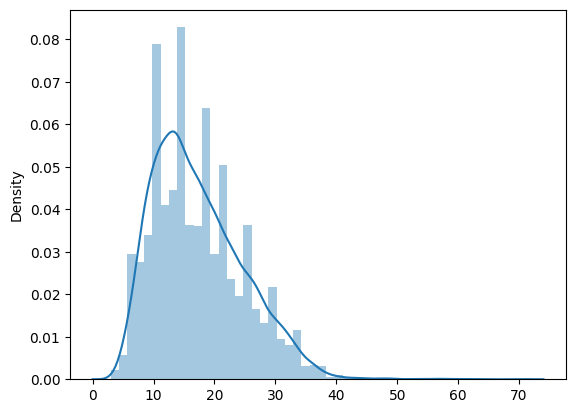

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#want to determine what number of tokens is best for the model
token_lens = []
for txt in training_dataset.proc_title:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)


In [5]:
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [6]:
from sentence_transformers.util import cos_sim

train_titles = training_dataset.proc_title.tolist()
train_embed = model.encode(train_titles, show_progress_bar=True)

val_titles = val_dataset.proc_title.tolist()
val_embed = model.encode(val_titles, show_progress_bar=True)

# sim = np.zeros((len(train_titles), len(train_titles)))

# for i in range(len(titles)):
#     sim[i:,i] = cos_sim(embeddings[i], embeddings[i:])

# sim

Batches: 100%|██████████| 172/172 [00:01<00:00, 98.28it/s] 


In [7]:
X_train, X_val, y_train, y_val = train_embed, val_embed, training_dataset.label_group, val_dataset.label_group

In [8]:
from sklearn.metrics import accuracy_score, f1_score
acc_dict = {}
f1_dict = {}
for k in [1, 2, 3, 5, 10, 25, 50, 100]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)

    # Evaluate the performance on the test set
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    acc_dict[k] = accuracy
    f1_dict[k] = f1

Text(0, 0.5, 'Score')

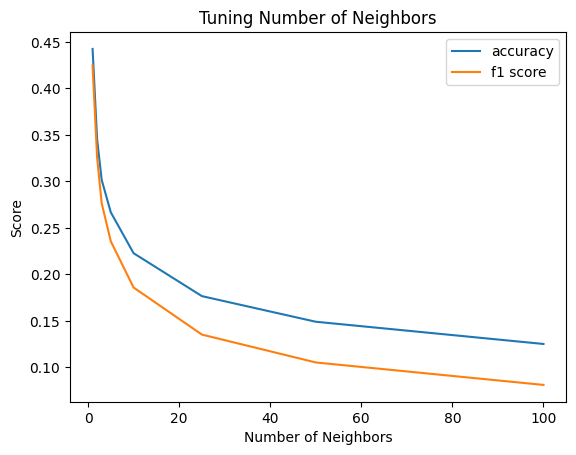

In [9]:
plt.plot(acc_dict.keys(), acc_dict.values(), label='accuracy')
plt.plot(f1_dict.keys(), f1_dict.values(), label='f1 score')
plt.legend()
plt.title('Tuning Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')

In [10]:
print(f'Ideal number of neighbors = {max(acc_dict, key=acc_dict.get)}')
print(f'Accuracy = {acc_dict[max(f1_dict, key=acc_dict.get)]}')
print(f'F1 Score = {f1_dict[max(acc_dict, key=acc_dict.get)]}')

Ideal number of neighbors = 1
Accuracy = 0.4425182481751825
F1 Score = 0.4246404640201221


In [11]:
test_titles = testing_dataset.proc_title.tolist()
test_embeddings = model.encode(test_titles, show_progress_bar=True)

Batches: 100%|██████████| 215/215 [00:02<00:00, 102.05it/s]


In [12]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(test_embeddings)
y_true = testing_dataset.label_group.tolist()
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy = {accuracy}')
print(f'F1 score = {f1}')

Accuracy = 0.3443795620437956
F1 score = 0.3183058563812007


## DistillBERT---------------------------

In [13]:
from sentence_transformers import SentenceTransformer, util
dist_model = SentenceTransformer('stsb-distilbert-base')
dist_model.max_seq_length = 128

train_titles = training_dataset.proc_title.tolist()
train_embed = dist_model.encode(train_titles, show_progress_bar=True)

val_titles = val_dataset.proc_title.tolist()
val_embed = dist_model.encode(val_titles, show_progress_bar=True)

Batches: 100%|██████████| 172/172 [00:01<00:00, 98.99it/s] 


In [14]:
from sklearn.metrics import accuracy_score, f1_score
acc_dict = {}
f1_dict = {}
X_train, X_val, y_train, y_val = train_embed, val_embed, training_dataset.label_group, val_dataset.label_group
for k in [1, 2, 3, 5, 10, 25, 50, 100]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)

    # Evaluate the performance on the test set
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    acc_dict[k] = accuracy
    f1_dict[k] = f1

Text(0, 0.5, 'Score')

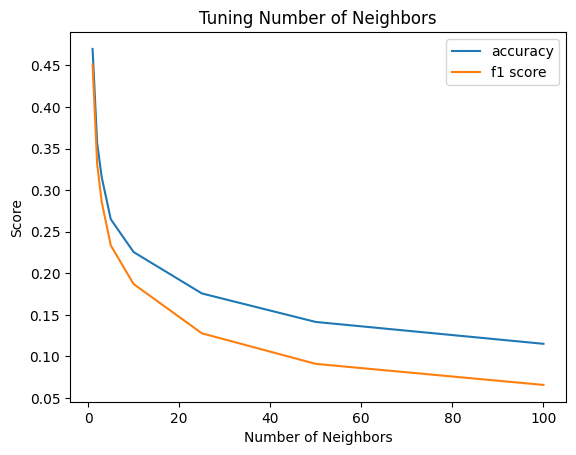

In [15]:
plt.plot(acc_dict.keys(), acc_dict.values(), label='accuracy')
plt.plot(f1_dict.keys(), f1_dict.values(), label='f1 score')
plt.legend()
plt.title('Tuning Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')

In [16]:
test_titles = testing_dataset.proc_title.tolist()
test_embeddings = model.encode(test_titles, show_progress_bar=True)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(test_embeddings)
y_true = testing_dataset.label_group.tolist()
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'Accuracy = {accuracy}')
print(f'F1 score = {f1}')

Batches: 100%|██████████| 215/215 [00:02<00:00, 95.29it/s] 


ValueError: X has 512 features, but KNeighborsClassifier is expecting 768 features as input.

Bad pipe message: %s [b'\x16\xbd\xdb\xb3\xefe{[p\xa2m\xb7\xce`bE\x89: O\xcac\xdcW\r']
Bad pipe message: %s [b'\x8e;tg,\xb9\xeaAI\xc4hX\x9be\xeb\x83\x99\xf3\xb7q\x13\xbf\x1b\xd3\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 4\xee\xccC&(\xdcb\xd37^\x05\xb2\xacw\xd2;\xee\x02*\x17\xf3`\xedF']
Bad pipe message: %s [b'\xbe\xb8mQP_\xfaV\x94\x90mg"\xa7\xb4w\xc2\x03\x00\x00']
Bad pipe message: %s [b",\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\